This notebook is dedicated to analysis of CorovaVirus (COVID-19) outbreak data. The notebook covers Azerbaijan case study. Analysis includes visualizations and predictions. Data are provided by John Hopkins University - https://github.com/CSSEGISandData/COVID-19

In [1]:
# import data manipulationa and visulization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('fivethirtyeight')
import datetime

#import statistical analysis labraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get data from https://github.com/CSSEGISandData/COVID-19, provided by Johns Hopkins University

confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [3]:
# # get data from https://github.com/CSSEGISandData/COVID-19, provided by Johns Hopkins University

# confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
# deaths = pd.read_csv('time_series_covid19_deaths_global.csv')
# recoveries = pd.read_csv('time_series_covid19_recovered_global.csv')

### Data Extraction for Azerbaijan

Let's create a separate dataframe for Azerbaijan

In [4]:
# extracting confirmed count for Azerbaijan
confirmed_AZE = confirmed[confirmed['Country/Region']=='Azerbaijan'] \
    .drop(columns=['Province/State', 'Lat', 'Long' ], axis=1) \
    .iloc[:, 1:] \
    .T
confirmed_AZE = confirmed_AZE.loc['3/31/20':]
date_index = pd.DatetimeIndex(confirmed_AZE.index)
confirmed_AZE.set_index(date_index, inplace=True)
# confirmed_AZE.head()

In [5]:
# extracting recovery count for Azerbaijan

recoveries_AZE = recoveries[recoveries['Country/Region']=='Azerbaijan'] \
    .drop(columns=['Province/State', 'Lat', 'Long' ], axis=1) \
    .iloc[:, 1:] \
    .T
recoveries_AZE = recoveries_AZE.loc['3/31/20':]
date_index = pd.DatetimeIndex(recoveries_AZE.index)
recoveries_AZE.set_index(date_index, inplace=True)
# recoveries_AZE.head()

In [6]:
# extracting death count for Azerbaijan

deaths_AZE = deaths[deaths['Country/Region']=='Azerbaijan'] \
    .drop(columns=['Province/State', 'Lat', 'Long' ], axis=1) \
    .iloc[:, 1:] \
    .T
deaths_AZE = deaths_AZE.loc['3/31/20':]
date_index = pd.DatetimeIndex(deaths_AZE.index)
deaths_AZE.set_index(date_index, inplace=True)
# deaths_AZE.head()

In [7]:
AZE_full = pd.concat([confirmed_AZE, recoveries_AZE, deaths_AZE], axis=1)
AZE_full.columns = ['confirmed', 'recovery', 'death']
AZE_full['active'] = AZE_full.confirmed - AZE_full.recovery - AZE_full.death
AZE_full['confirmed_daily'] = AZE_full.confirmed.diff()
AZE_full['recovery_daily'] = AZE_full.recovery.diff()
AZE_full['death_daily'] = AZE_full.death.diff()
AZE_full['active_daily'] = AZE_full.active.diff()
AZE_full['net_active'] = AZE_full.confirmed_daily - (AZE_full.recovery_daily + AZE_full.death_daily)
AZE_full[AZE_full.columns[4:]] = AZE_full[AZE_full.columns[4:]].fillna(0.0).astype(int)

AZE_full = AZE_full[1:]
AZE_full.tail()

,confirmed,recovery,death,active,confirmed_daily,recovery_daily,death_daily,active_daily,net_active
2020-06-09,8191,4606,98,3487,315,229,5,81,81
2020-06-10,8530,4720,102,3708,339,114,4,221,221
2020-06-11,8882,4930,108,3844,352,210,6,136,136
2020-06-12,9218,5116,113,3989,336,186,5,145,145
2020-06-13,9570,5309,115,4146,352,193,2,157,157


### Current Situation

We are primarily interested in trend of Active count. Below we can see daily net change in Active count.

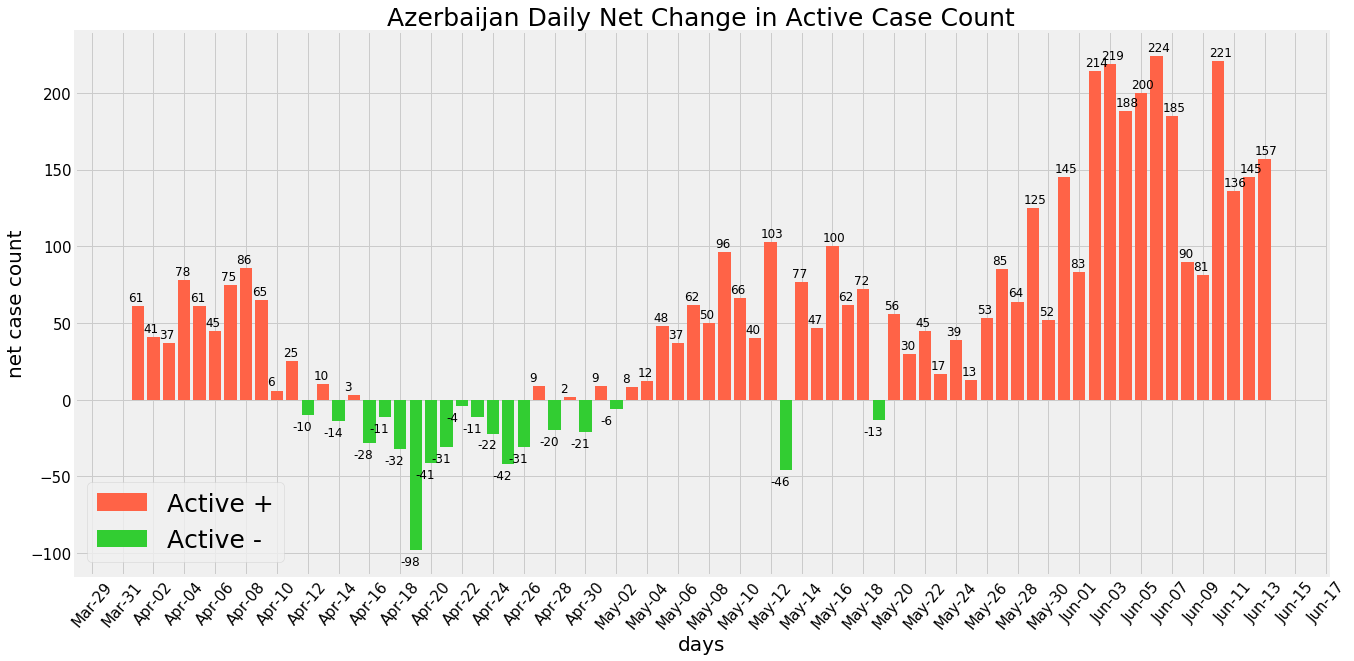

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Azerbaijan Daily Net Change in Active Case Count', size=25)

active_plus = AZE_full.net_active.where(AZE_full.net_active > 0, np.nan)
active_plus_bars = ax.bar(active_plus.index, active_plus, label='Active +', color='tomato')
for i in np.arange(len(AZE_full)):
    ax.annotate(active_plus_bars[i].get_height().astype('Int64'),
    xy=(active_plus_bars[i].get_x() + active_plus_bars[i].get_width()/20, active_plus_bars[i].get_height()),  
    xytext=(-4, 5), textcoords="offset points", size=12)

active_minus = AZE_full.net_active.where(AZE_full.net_active < 0, np.nan)
active_minus_bars = ax.bar(active_minus.index, active_minus, label='Active -', color='limegreen')
for i in np.arange(len(AZE_full)):
    ax.annotate(active_minus_bars[i].get_height().astype('Int64'),
    xy=(active_minus_bars[i].get_x() + active_minus_bars[i].get_width()/20, active_minus_bars[i].get_height()),
    xytext=(-10,-15), textcoords="offset points", size=12)    
    
ax.set_ylabel('net case count', size=20)
ax.set_xlabel('days', size=20)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15, rotation=50)

ax.legend(fontsize=25)

plt.savefig("AZE_net_active_daily_case")

As we can see the situation was stabilizing in the second half of April, though it again began to worsen in May. The most decrease in Active case count was on April 19 (-98) and the most increase was on May 29th (+125)

In [9]:
# create a function to plot daily trends

def plot_specific_trend(df, title, interval, ylabel):
    plt.figure(figsize=(18, 7))
    plt.plot(df.index, df, linewidth=5)
    plt.title(title, size=25)
    plt.grid(alpha = 2)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlabel('date', size=20)
    plt.ylabel(ylabel, size=20)

## Forecasting based on Confirmed case count

Lets make forecasting based on daily Confirmed case count. We are going to use Box-Jenkins methodology.

In [10]:
# save coonfirmed daily count in a separate DF
confirmed_daily = AZE_full.confirmed_daily
confirmed_daily.tail()

2020-06-09    315
2020-06-10    339
2020-06-11    352
2020-06-12    336
2020-06-13    352
Name: confirmed_daily, dtype: int32

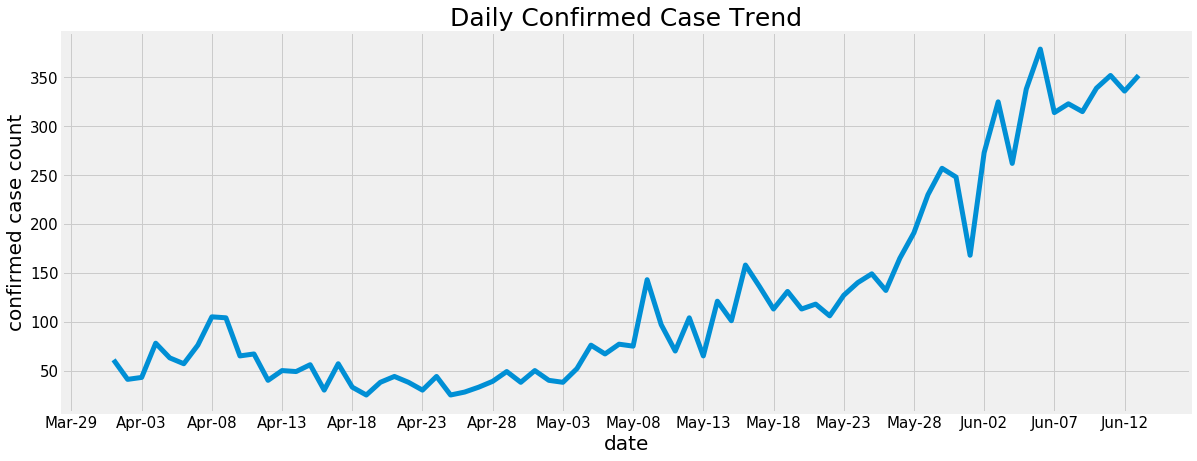

In [11]:
plot_specific_trend(confirmed_daily, 'Daily Confirmed Case Trend', 5, 'confirmed case count')

### June 14 Update

Since we developed our model on 8th of June (based on data until 8th of June), we need to selected the range of data that we used for modeling. In other words we are not going to change the model, as we are going to check our model - forecast vs actual

In [12]:
confirmed_daily = AZE_full.loc[:'2020-06-07', 'confirmed_daily']

In [13]:
confirmed_daily.tail()

2020-06-03    325
2020-06-04    262
2020-06-05    338
2020-06-06    379
2020-06-07    314
Name: confirmed_daily, dtype: int32


### Stationarity check and optimal order for difference

First we need to check if the data is stationary so that we can use ARIMA model for forecasting. To check stationarity we will first visualizae the data and then apply Dicky-Fuller test

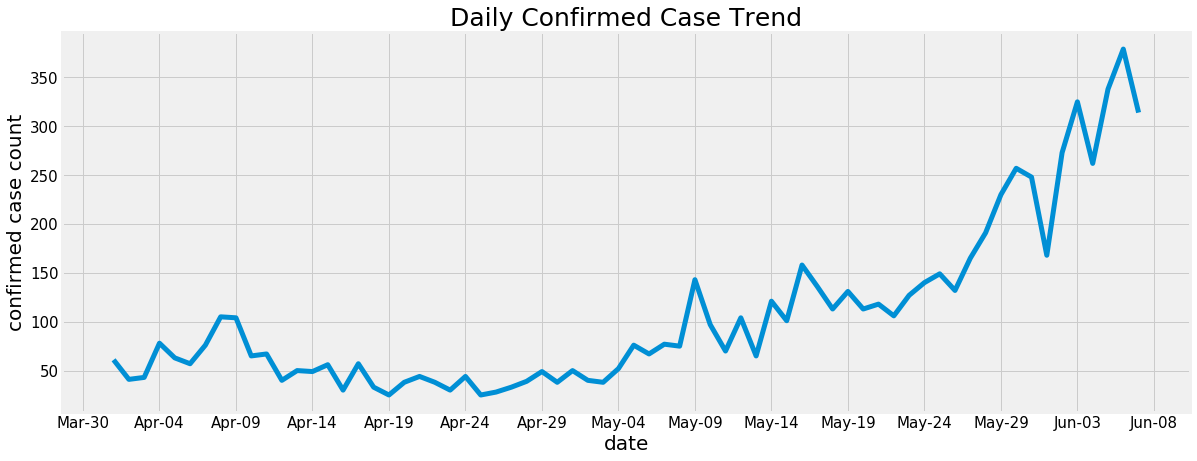

In [14]:
plot_specific_trend(confirmed_daily, 'Daily Confirmed Case Trend', 5, 'confirmed case count')

In [15]:
# Dicky-Fuller test
confirmed_result = adfuller(confirmed_daily)

# Get Test statistics and p-value
print('Test Statistic: %f' % confirmed_result[0])
print('p-value: %f' % confirmed_result[1])

Test Statistic: 2.050192
p-value: 0.998735


Based on analysis above we can conclude that our confirmed daily data is non-stationary - we cannot reject the null hypothesis. We have to make tranformation by taking first order difference for forecasting.

In [16]:
confirmed_daily_1stdiff = confirmed_daily.diff().dropna()
confirmed_result_1stdiff = adfuller(confirmed_daily_1stdiff)
print('Test Statistic: %f' % confirmed_result_1stdiff[0])
print('p-value: %f' % confirmed_result_1stdiff[1])

Test Statistic: -9.305984
p-value: 0.000000


Now our test statistics is less than previous one and p-value is less than 5%. We can therefore reject the null hypothesys (non-stationarity) and conclude that 1st order difference results in stationary data. Let's check it visually too.

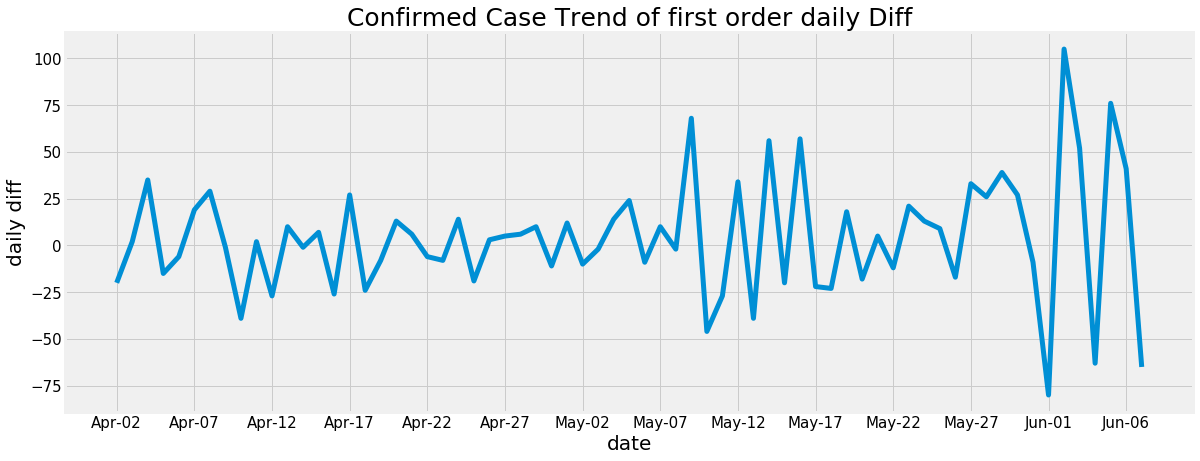

In [17]:
plot_specific_trend(confirmed_daily_1stdiff, 'Confirmed Case Trend of first order daily Diff', 5, 'daily diff')

Based on plot above too the data look stationary.

Let's also check 2nd order differencing

In [18]:
confirmed_daily_2stdiff = confirmed_daily_1stdiff.diff().dropna()
confirmed_result_2stdiff = adfuller(confirmed_daily_2stdiff)
print('Test Statistic: %f' % confirmed_result_2stdiff[0])
print('p-value: %f' % confirmed_result_2stdiff[1])

Test Statistic: -7.266360
p-value: 0.000000


Although, p-value is still less than 5%, test statisctics is more than previous one (with 1st order diff). Bason on this analysis we can tentatively select 1 as differening term for ARIMA model. However, I will also check other options, as well, for differencing term. It should also be noted that we have to also avoid overdifferencing. We should therefore be cautious.

### Training ARIMA model

Before training the model we need to guess model orders for Autoregression (AR) and Moving Average(MA). For this we can intially check Autocorrelation and Partial Autocorrelation functions of the data. Below are plots for ACF and PACF for 10 lags 

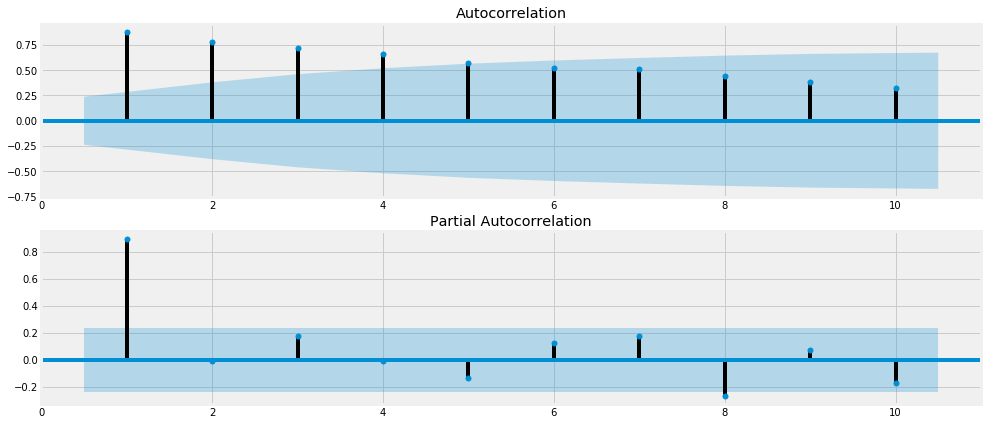

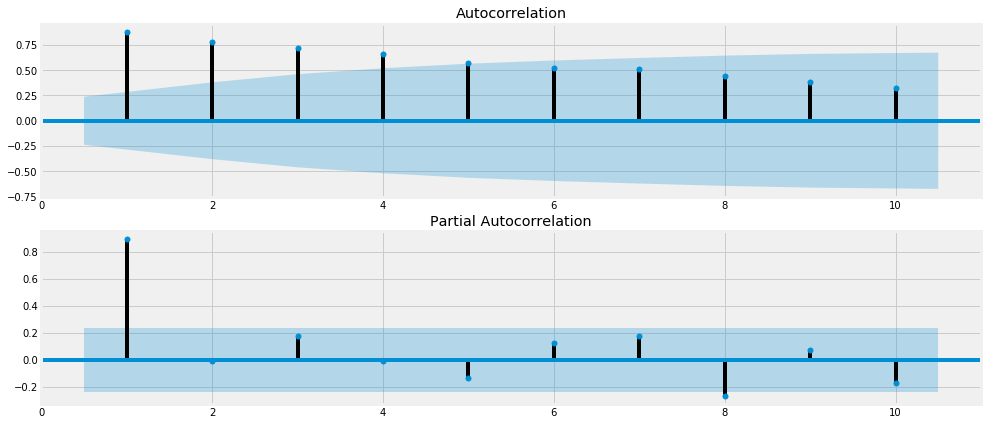

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,7))
 
# Plot acf
plot_acf(confirmed_daily, lags=10, zero=False, ax=ax1)

# Plot pacf
plot_pacf(confirmed_daily, lags=10, zero=False, ax=ax2)

It is difficult to say something about AR and MA model orders based on plots above. However, based on confidence intervals above we can narrow down the range of AR and MA terms for ARIMA model to 5.
Let's make a grid search of order parameters for ARIMA model. I will also check AIC (Akaike information criterion) and BIC (Bayesian information criterion) to find optimal orders for AR and MA

In [20]:
# save grid search result to a list
grid_search_result =[]

# Looping over p values from 0 to 5.
for p in range(6):
    for q in range(6):
        model = SARIMAX(confirmed_daily, order=(p,1,q))
        results = model.fit()
        grid_search_result.append((p, q, results.aic, results.bic))
        
# save results to a pandas DF
grid_search_result_df = pd.DataFrame(grid_search_result, columns=['p','q', 'aic', 'bic'])
grid_search_result_df

,p,q,aic,bic
0,0,0,657.428241,659.632933
1,0,1,649.980936,654.390322
2,0,2,651.979698,658.593775
3,0,3,649.533362,658.352132
4,0,4,651.388975,662.412438
5,0,5,652.522575,665.750731
6,1,0,652.982954,657.392339
7,1,1,651.980613,658.594691
8,1,2,651.256345,660.075116
9,1,3,651.197975,662.221438


Since AIC is better for predictive models, models with lowest AIC will be chosen for model building

In [21]:
grid_search_result_df.sort_values('aic').head()

,p,q,aic,bic
19,3,1,647.683492,658.706955
12,2,0,648.284179,654.898257
11,1,5,648.873501,664.306349
18,3,0,649.184377,658.003147
3,0,3,649.533362,658.352132


In [22]:
grid_search_result_df.sort_values('bic').head()

,p,q,aic,bic
1,0,1,649.980936,654.390322
12,2,0,648.284179,654.898257
6,1,0,652.982954,657.392339
18,3,0,649.184377,658.003147
3,0,3,649.533362,658.352132


Based on table above order of (3,1) can be chosen as best candidate for a predcitive model. I will also keep other top orders in mind to potentially find the best predictions

### Model diagnostics

In [23]:
# 3,1,1 ARIMA model
model = SARIMAX(confirmed_daily, order=(3, 1, 1))
result_311 = model.fit()

In [24]:
# residuals for 3,1,1 model and Mean Absolute Error
residuals_311 = result_311.resid
mae_311 = np.mean(np.abs(residuals_311))
mae_311

21.34325563047846

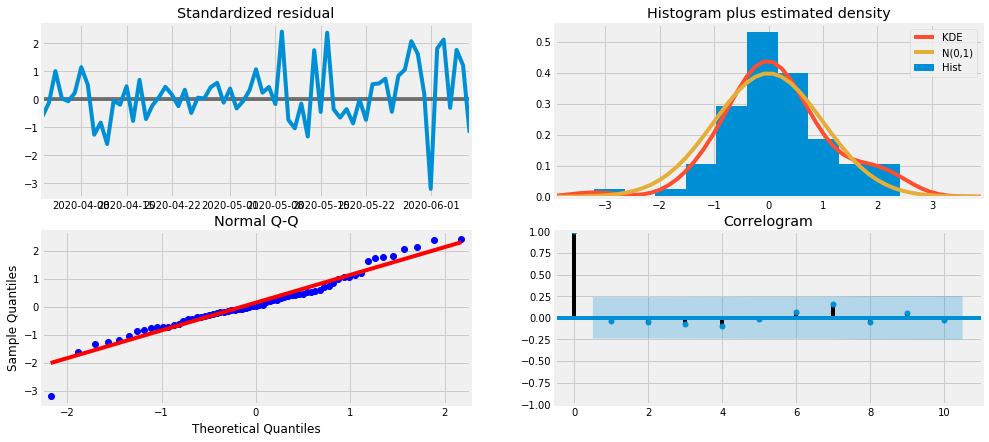

In [25]:
# diagostics plots
result_311.plot_diagnostics(figsize=(15,7))
plt.show()

We see no obvious pattern for Standardized residual and it fluctuates around 0.
KDE of histogram more or less overlaps with residual distribution. We can see residuals are normally distributed from Normal Q-Q diagram (except some values). Finally, ACF plot shows the residual errors are not autocorrelated

In [26]:
# model summary
result_311.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        confirmed_daily   No. Observations:                   68
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -318.842
Date:                Sun, 14 Jun 2020   AIC                            647.683
Time:                        14:33:55   BIC                            658.707
Sample:                    04-01-2020   HQIC                           652.046
                         - 06-07-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4627      0.203      2.279      0.023       0.065       0.861
ar.L2          0.0830      0.120      0.692      0.489      -0.152       0.318
ar.L3          0.4174      0.109      3.818      0.000       0.203       0.632
ma.L1         -0.9025      0.230     -3.924      0.000      -1.353      -0.452
sigma2       783.6490    121.589      6.445      0.000     545.339    1021.959
===================================================================================
Ljung-Box (Q):                       24.46   Jarque-Bera (JB):                 3.56
Prob(Q):                              0.97   Prob(JB):                         0.17
Heteroskedasticity (H):               3.59   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Summary above, as well, reveals some information. All model orders are significant, except for AR(2). But it is ok. If to check other parameter combinations we will not get a better result (we will get other insignificant parameters or higher AIC values). The process of checking other parameter combinations and order p-values is omitted here.

It is time to make forecast

In [27]:
# Actual vs Forecast for last 30 days
forecast_311 = result_311.get_prediction(start=-30, dynamic=False)
# prediction mean
forecast_mean = forecast_311.predicted_mean
# confidence intervals of predictions
confidence_intervals = forecast_311.conf_int()
lower_limits = confidence_intervals.loc[:,'lower confirmed_daily']
upper_limits = confidence_intervals.loc[:,'upper confirmed_daily']

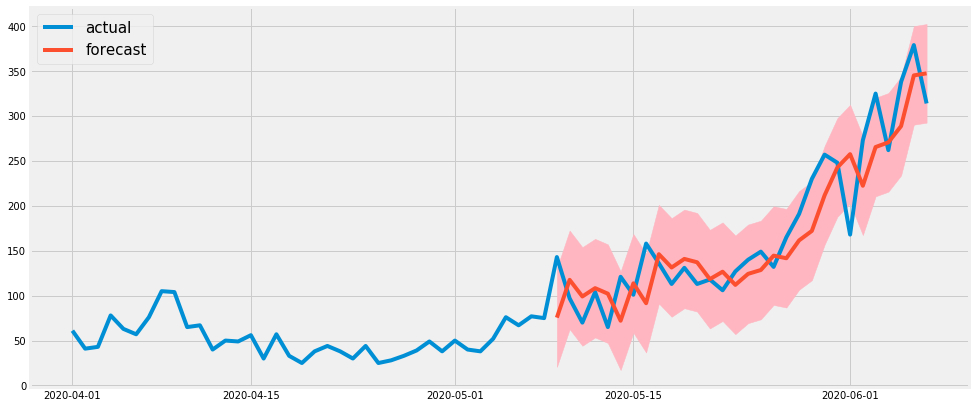

In [28]:
plt.figure(figsize=(15,7))
plt.plot(confirmed_daily, label='actual')
#plot forecast for last 30 days
plt.plot(forecast_mean, label='forecast')
#plot confidence intervals
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='lightpink')
plt.legend(fontsize=15)

It looks like we have a good prediction model. However, in this case we made an in-sample lagged values of previous day to make a next day predtion, i.e. we made one-step-ahead predictions. For better forecasting we need to make a dynamic prediction. Let's firslty, make an in-sample dynamic prediciton. 

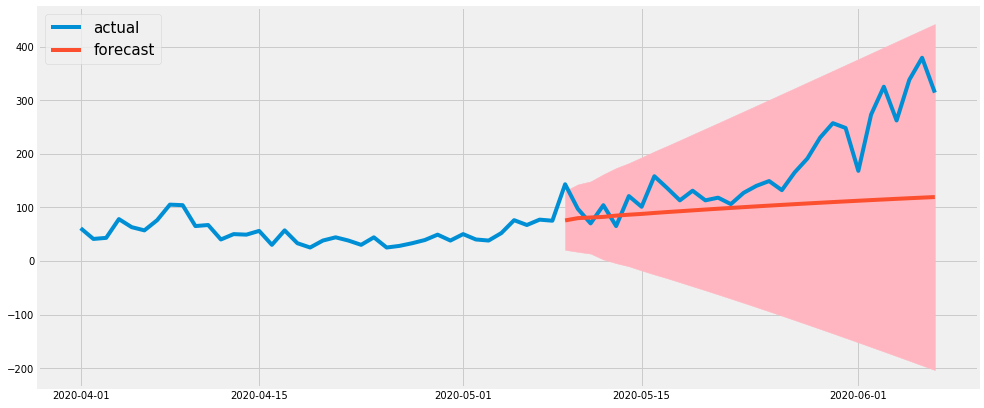

In [29]:
# Actual vs Forecast for last 30 days
forecast_311_dyn = result_311.get_prediction(start=-30, dynamic=True)
# prediction mean
forecast_mean_dyn = forecast_311_dyn.predicted_mean
# confidence intervals of predictions
confidence_intervals_dyn = forecast_311_dyn.conf_int()
lower_limits_dyn = confidence_intervals_dyn.loc[:,'lower confirmed_daily']
upper_limits_dyn = confidence_intervals_dyn.loc[:,'upper confirmed_daily']

plt.figure(figsize=(15,7))
plt.plot(confirmed_daily, label='actual')
#plot forecast for last 30 days
plt.plot(forecast_mean_dyn, label='forecast')
#plot confidence intervals
plt.fill_between(lower_limits_dyn.index, lower_limits_dyn, upper_limits_dyn, color='lightpink')
plt.legend(fontsize=15, loc='upper left')

In case of dynamic predictions the further we go, the more there is uncertainty - therefore confidence interval becomes wider. We can observe that the forecast generally captures the actual data direction correctly, even though forecast is consistenly low for the last 10-15 days.

### Future forecast with (3, 1, 1) orders

We can now make a future forecast, we we have a confidence in our model

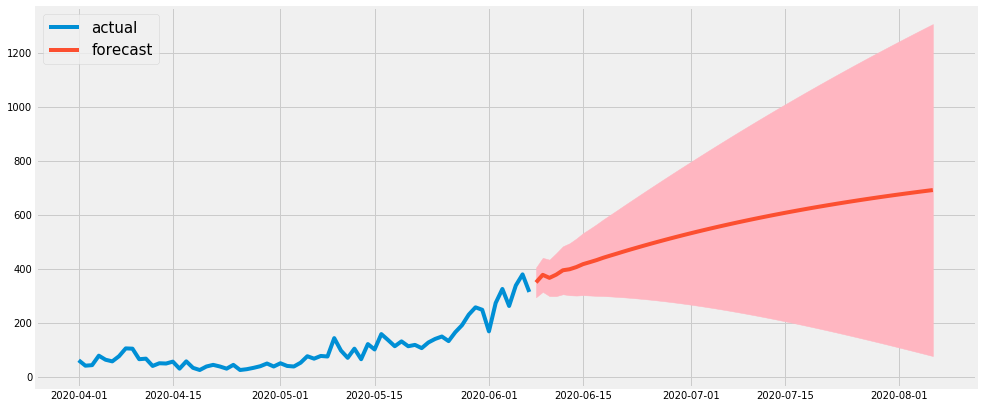

In [30]:
# Forecast for the future days
forecast_311_future = result_311.get_forecast(steps=60)
# forecast mean
future_forecast_mean = forecast_311_future.predicted_mean
# confidence intervals of forecast
confidence_intervals_future = forecast_311_future.conf_int()
lower_limits_future = confidence_intervals_future.loc[:,'lower confirmed_daily']
upper_limits_future = confidence_intervals_future.loc[:,'upper confirmed_daily']

plt.figure(figsize=(15,7))
plt.plot(confirmed_daily, label='actual')
# plot forecast
plt.plot(future_forecast_mean, label='forecast')
# plot confidence intervals
plt.fill_between(lower_limits_future.index, lower_limits_future, upper_limits_future, color='lightpink')
plt.legend(fontsize=15, loc='upper left')

In [31]:
confirmed_daily.tail(10)

2020-05-29    230
2020-05-30    257
2020-05-31    248
2020-06-01    168
2020-06-02    273
2020-06-03    325
2020-06-04    262
2020-06-05    338
2020-06-06    379
2020-06-07    314
Name: confirmed_daily, dtype: int32

### Chekcing other options for differencing parameters

In [32]:
# save grid search result to a list
grid_search_result =[]

# Looping over p values from 0 to 5.
for p in range(3):
    for q in range(3):
        for d in range(3):
            model = SARIMAX(confirmed_daily, order=(p,d,q))
            results = model.fit()
            grid_search_result.append((p, d, q, results.aic, results.bic))
        
# save results to a pandas DF
grid_search_result_df = pd.DataFrame(grid_search_result, columns=['p','d','q', 'aic', 'bic'])
grid_search_result_df

,p,d,q,aic,bic
0,0,0,0,863.054683,865.274191
1,0,1,0,657.428241,659.632933
2,0,2,0,709.719956,711.909611
3,0,0,1,791.160314,795.599329
4,0,1,1,649.980936,654.390322
5,0,2,1,653.925188,658.304497
6,0,0,2,761.611776,768.270299
7,0,1,2,651.979698,658.593775
8,0,2,2,640.038046,646.607010
9,1,0,0,672.448789,676.887805


In [33]:
grid_search_result_df.sort_values('aic').head()

,p,d,q,aic,bic
23,2,2,1,639.093159,647.851778
8,0,2,2,640.038046,646.607010
26,2,2,2,641.083117,652.031391
17,1,2,2,641.717104,650.475723
19,2,1,0,648.284179,654.898257


In [34]:
grid_search_result_df.sort_values('bic').head()

,p,d,q,aic,bic
8,0,2,2,640.038046,646.607010
23,2,2,1,639.093159,647.851778
17,1,2,2,641.717104,650.475723
26,2,2,2,641.083117,652.031391
4,0,1,1,649.980936,654.390322


As we see orders of (2,1,1) is the best candidate based on both AIC and BIC values. We will use these parameters further for forecasting

In [35]:
# 2,2,1 ARIMA model
model = SARIMAX(confirmed_daily, order=(2, 2, 1))
result_221 = model.fit()

In [36]:
# residuals for 2,2,1 model and Mean Absolute Error
residuals_221 = result_221.resid
mae_221 = np.mean(np.abs(residuals_221))
mae_221

22.452173329019015

In [37]:
mae_311

21.34325563047846

MAE is more than the previous one (311), but let's analyze the new model further

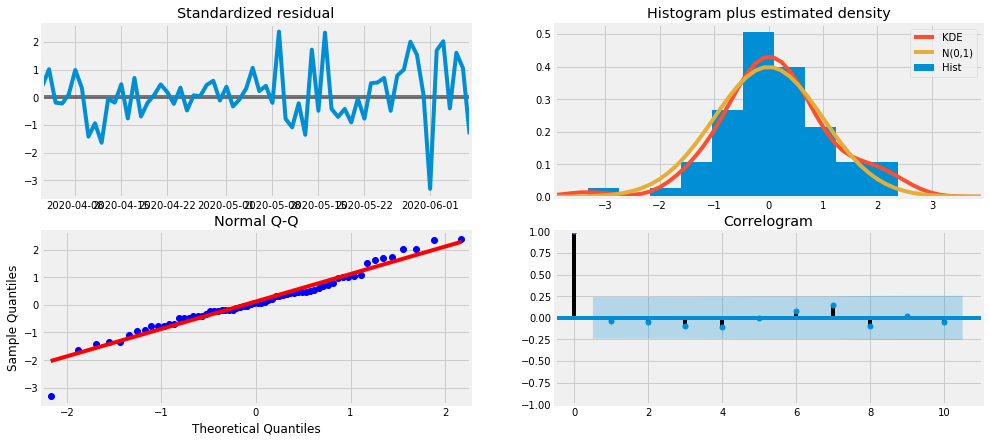

In [38]:
# diagostics plots
result_221.plot_diagnostics(figsize=(15,7))
plt.show()

Plot results do not differ much from (311) model

In [39]:
# (2,2,1) model summary
result_221.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:        confirmed_daily   No. Observations:                   68
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -315.547
Date:                Sun, 14 Jun 2020   AIC                            639.093
Time:                        14:34:00   BIC                            647.852
Sample:                    04-01-2020   HQIC                           642.554
                         - 06-07-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5269      0.101     -5.196      0.000      -0.726      -0.328
ar.L2         -0.4328      0.113     -3.845      0.000      -0.653      -0.212
ma.L1         -0.9064      0.051    -17.729      0.000      -1.007      -0.806
sigma2       789.4431    116.379      6.783      0.000     561.345    1017.541
===================================================================================
Ljung-Box (Q):                       25.39   Jarque-Bera (JB):                 4.71
Prob(Q):                              0.97   Prob(JB):                         0.09
Heteroskedasticity (H):               3.42   Skew:                            -0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This time we see a better results than 311 model, since all model orders are significant. Additionally, AIC and BIC both are less for 221 model, than 311 model. I tlooks like 221 is our best model.

In [40]:
# Actual vs Forecast for last 30 days
forecast_221 = result_221.get_prediction(start=-30, dynamic=False)
# prediction mean
forecast_mean = forecast_221.predicted_mean
# confidence intervals of predictions
confidence_intervals = forecast_221.conf_int()
lower_limits = confidence_intervals.loc[:,'lower confirmed_daily']
upper_limits = confidence_intervals.loc[:,'upper confirmed_daily']

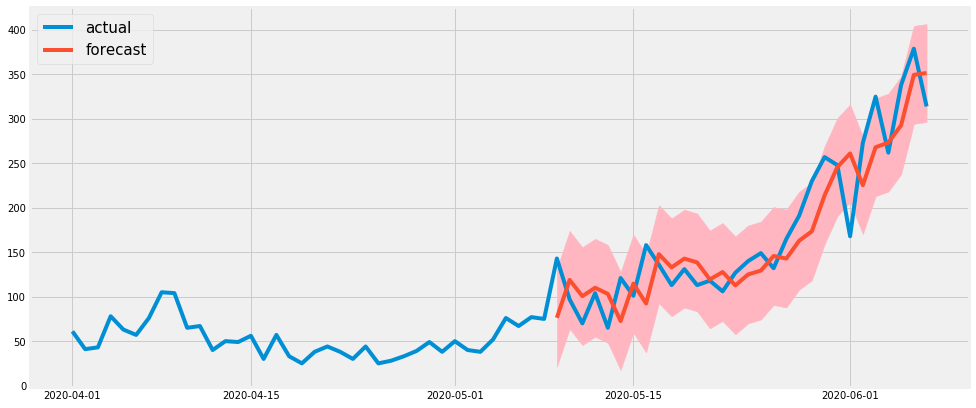

In [41]:
plt.figure(figsize=(15,7))
plt.plot(confirmed_daily, label='actual')
# plot forecast
plt.plot(forecast_mean, label='forecast')
# plot confidence intervals
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='lightpink')
plt.legend(fontsize=15)

Predicition model looks ok. Here  is the result for dynamic forecasting.

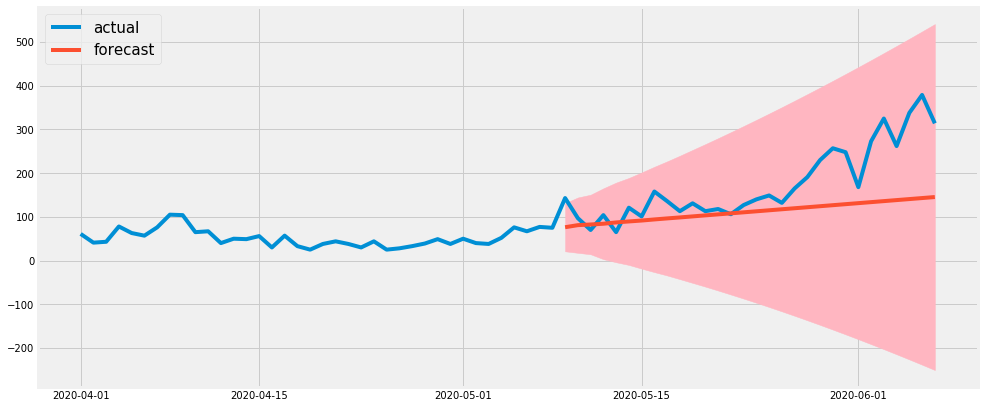

In [42]:
# Actual vs Forecast for last 30 days
forecast_221_dyn = result_221.get_prediction(start=-30, dynamic=True)
# prediction mean
forecast_mean_dyn = forecast_221_dyn.predicted_mean
# confidence intervals of predictions
confidence_intervals_dyn = forecast_221_dyn.conf_int()
lower_limits_dyn = confidence_intervals_dyn.loc[:,'lower confirmed_daily']
upper_limits_dyn = confidence_intervals_dyn.loc[:,'upper confirmed_daily']

plt.figure(figsize=(15,7))
plt.plot(confirmed_daily, label='actual')
#plot forecast for last 30 days
plt.plot(forecast_mean_dyn, label='forecast')
#plot confidence intervals
plt.fill_between(lower_limits_dyn.index, lower_limits_dyn, upper_limits_dyn, color='lightpink')
plt.legend(fontsize=15, loc='upper left')

As with 311 model, forecast is consistenly low for the last 10-15 days.

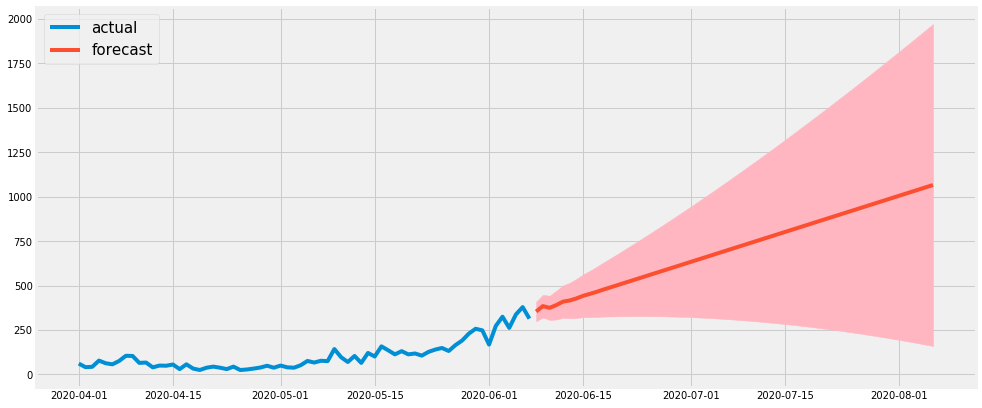

In [43]:
# Forecast for the next 60 days
forecast_221_future = result_221.get_forecast(steps=60)
# forecast mean
future_forecast_mean = forecast_221_future.predicted_mean
# confidence intervals of forecast
confidence_intervals_future = forecast_221_future.conf_int()
lower_limits_future = confidence_intervals_future.loc[:,'lower confirmed_daily']
upper_limits_future = confidence_intervals_future.loc[:,'upper confirmed_daily']

plt.figure(figsize=(15,7))
plt.plot(confirmed_daily, label='actual')
# plot forecast
plt.plot(future_forecast_mean, label='forecast')
# plot confidence intervals
plt.fill_between(lower_limits_future.index, lower_limits_future, upper_limits_future, color='lightpink')
plt.legend(fontsize=15, loc='upper left')

In [44]:
lower_limits_future.head(10)

2020-06-08    298.978199
2020-06-09    321.325768
2020-06-10    306.629982
2020-06-11    309.286091
2020-06-12    318.805510
2020-06-13    316.925495
2020-06-14    318.046560
2020-06-15    322.168716
2020-06-16    322.975985
2020-06-17    323.846282
Freq: D, Name: lower confirmed_daily, dtype: float64

In [45]:
confirmed_daily.tail(10)

2020-05-29    230
2020-05-30    257
2020-05-31    248
2020-06-01    168
2020-06-02    273
2020-06-03    325
2020-06-04    262
2020-06-05    338
2020-06-06    379
2020-06-07    314
Name: confirmed_daily, dtype: int32

Based on analysis above we can conclude that even though there is no much difference between models of 311 and 221, the second model is better when taking into account all factors from model results and diagnostics. 

Let's plot final forecast data again with 221 model and make some addtions to the plot

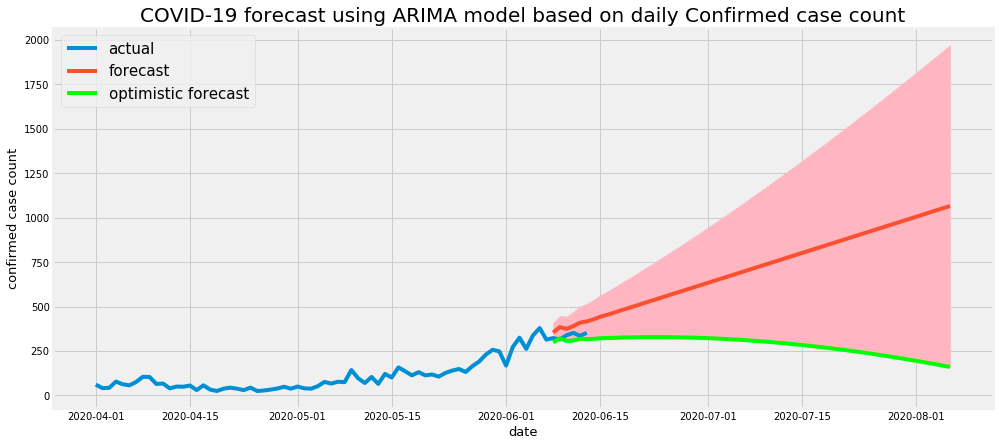

In [46]:
# Forecast for the next 60 days
forecast_221_future = result_221.get_forecast(steps=60)

# forecast mean
future_forecast_mean = forecast_221_future.predicted_mean

# confidence intervals of forecast
confidence_intervals_future = forecast_221_future.conf_int()
lower_limits_future = confidence_intervals_future.loc[:,'lower confirmed_daily']
upper_limits_future = confidence_intervals_future.loc[:,'upper confirmed_daily']

# plot figure and title
plt.figure(figsize=(15,7))
plt.title('COVID-19 forecast using ARIMA model based on daily Confirmed case count', size=20)

# plot actual
plt.plot(AZE_full.confirmed_daily, label='actual')

# plot forecast and optimistic forecast
plt.plot(future_forecast_mean, label='forecast')
plt.plot(lower_limits_future, color='lime', label='optimistic forecast')

# plot confidence intervals
plt.fill_between(lower_limits_future.index, lower_limits_future, upper_limits_future, color='lightpink')

plt.legend(fontsize=15, loc='upper left')
plt.grid(alpha = 2)
plt.xlabel('date', size=13)
plt.ylabel('confirmed case count', size=13)
plt.savefig('Azerbaijan COVID-19 forecasting using ARIMA model')

### Conclusion

It is not generally recommended to make a forecast for COVID-19, using any machine learning or any other forecasting techniques, since there is high uncertainty due to unpredictable human behavior and government actions. Nevertheless, using historic data we can make forecasting within some confidence band limits. We can later make some adjustments to forecasting to make it more realistic.

In this study, I used the ARIMA time series forecasting model to predict the confirmed case count for the next 60 days in Azerbaijan. Here I am going to be optimistic - take lower confidence interval limit (the green line) as a forecast, since it has a decreasing trend. Note that thanks to Azerbaijan government hardened measurements in the first week of June, the forecasted trend line (of lower limit) can bend even further in the second half of June (since the effect of measurements will be seen in 10-15 days). I hope we will reach a 2-digit or 1-digit new daily confirmed case count until mid-July. 


<u>June 14 Update</u>:
When comparing first week actual data after forecst with forecasted data we see that actual trend is within confidence interval limits - it is between optimistic forecast and mean forecast. 

